In [1]:
import sys, os
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
root_dir = '/mnt/home/spandey/ceph/CHARM/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from charm.utils_data_prep_cosmo_vel_conc_peak import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml
import pickle as pk
# autoreload modules
import matplotlib
import matplotlib.pyplot as pl

abs_path_config = os.path.abspath(root_dir + "run_configs/") 
abs_path_data = os.path.abspath(root_dir + "data/") 
abs_path_checkpoint = os.path.abspath(root_dir + "model_checkpoints/") 
%load_ext autoreload
%autoreload 2




In [2]:
run_config_name = 'TRAIN_CONC_FIDCOSMO_cond_fastpm_ns128_200c.yaml'
with open(abs_path_config + '/' + run_config_name,"r") as file_object:
    config=yaml.load(file_object,Loader=yaml.SafeLoader)


config_sims = config['sim_settings']
ji_array = np.arange(int(config_sims['nsims']))
nsubvol_per_ji = int(config_sims['nsubvol_per_ji'])
nsubvol_fid = int(config_sims['nsubvol_fid'])
subsel_criteria = config_sims['subsel_criteria']
num_cosmo_params = int(config_sims['num_cosmo_params'])
ns_d = config_sims['ns_d']
nb = config_sims['nb']
nax_d =  ns_d // nb
nf = config_sims['nf']
layers_types = config_sims['layers_types']
z_inference = config_sims['z_inference']
nc = 0
for jl in range(len(layers_types)):
    if layers_types[jl] == 'cnn':
        nc += 1
    elif layers_types[jl] == 'res':
        nc += 2
    else:
        raise ValueError("layer type not supported")

z_all = config_sims['z_all']
z_all_FP = config_sims['z_all_FP']

ns_h = config_sims['ns_h']
nax_h = ns_h // nb
cond_sim = config_sims['cond_sim']

nsims_per_batch = config_sims['nsims_per_batch']
nbatches_train = config_sims['nbatches_train']

mass_type = config_sims['mass_type']
lgMmin = config_sims['lgMmin']
lgMmax = config_sims['lgMmax']
cmin = config_sims['cmin']
cmax = config_sims['cmax']

stype = config_sims['stype']
rescale_sub = config_sims['rescale_sub']
lgMmincutstr = config_sims['lgMmincutstr']
# subsel_highM1 = config_sims['subsel_highM1']
# nsubsel = config_sims['nsubsel']
is_HR = config_sims['is_HR']

try:
    Nmax = config_sims['Nmax']
except:
    Nmax = 4

config_net = config['network_settings']
hidden_dim_MAF = config_net['hidden_dim_MAF']
learning_rate = config_net['learning_rate']
# K_M1 = config_net['K_M1']
# B_M1 = config_net['B_M1']
# nflows_M1_NSF = config_net['nflows_M1_NSF']
K_conc = config_net['K_conc']
B_conc = config_net['B_conc']
nflows_conc_NSF = config_net['nflows_conc_NSF']

# base_dist_Ntot = config_net['base_dist_Ntot']
# if base_dist_Ntot == 'None':
#     base_dist_Ntot = None
# base_dist_M1 = config_net['base_dist_M1']
base_dist_conc = config_net['base_dist_conc']

cond_Mass_for_conc = config_net['cond_Mass_for_conc']

# ngauss_M1 = config_net['ngauss_M1']

changelr = config_net['changelr']
ksize = nf
nfeature_cnn = config_net['nfeature_cnn']
nout_cnn = 4 * nfeature_cnn
if cond_sim == 'fastpm':
    if any('v' in str(string) for string in z_all_FP):
        ninp = len(z_all_FP) + 2
    else:
        ninp = len(z_all_FP)

elif cond_sim == 'quijote':
    ninp = len(z_all)
else:
    raise ValueError("cond_sim not supported")

num_cond = nout_cnn + ninp + num_cosmo_params



In [3]:
import pickle as pk
import numpy as np

df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train, df_vh_train, df_ch_train, df_nuh_train, ind_subsel_all_train, ind_subsel_fid_train, cosmo_val_all_train = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
    sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH',
    sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self',  
    LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria='all', is_HR = is_HR,  vel_type='diff',conc_type='diff',
    get_density=False, 
    get_halos=True
    )



In [57]:
import pickle as pk
import numpy as np

_,_,_,_,_, df_ch_train_sim_total, _,_,_,_ = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
    sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH',
    sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self',  
    LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria='all', is_HR = is_HR,  vel_type='diff',conc_type='sim',
    get_density=False, 
    get_halos=True
    )



In [58]:
import pickle as pk
import numpy as np

_,_,_,_,_, df_ch_train_func_total, _,_,_,_ = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
    sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_LH',
    sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self',  
    LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria='all', is_HR = is_HR,  vel_type='diff',conc_type='func',
    get_density=False, 
    get_halos=True
    )



In [5]:
df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, df_vh_train_FP, df_ch_train_FP, df_nuh_train_FP, ind_subsel_all_train_FP, ind_subsel_fid_train_FP, cosmo_val_all_train_FP = load_density_halo_data_NGP(
    ji_array, ns_d, nb, nf, nc, z_all_FP, ns_h,z_inference=z_inference,nsubvol_per_ji=nsubvol_per_ji,nsubvol_fid=nsubvol_fid,
    sdir_cosmo='/mnt/home/spandey/ceph/Quijote/data_NGP_self_fastpm_LH',
    sdir_fid='/mnt/home/spandey/ceph/Quijote/data_NGP_self/fastpm',  
    LH_cosmo_val_file='/mnt/home/spandey/ceph/Quijote/latin_hypercube_params.txt',  
    stype=stype, mass_type=mass_type, lgMmincutstr = lgMmincutstr, subsel_criteria=subsel_criteria,
    indsubsel_all_inp=ind_subsel_all_train,
    indsubsel_fid_inp=ind_subsel_fid_train,
    is_HR = is_HR,  vel_type='diff',
    get_density=True,
    get_halos=False
    )
if cosmo_val_all_train_FP is None:
    cosmo_val_all_train_FP = cosmo_val_all_train




0it [00:00, ?it/s]


In [78]:
# df_d_all_train_FP.shape, df_d_all_nsh_train_FP.shape
# cmin = -20
# cmax = 20

return_dict_train = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train,cosmo_val_all_train, df_v_inp=None, df_c_inp=df_ch_train, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax, get_density=False, get_halos=True, cmin=cmin, cmax=cmax
    )

return_dict_train_sim_total = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train,cosmo_val_all_train, df_v_inp=None, df_c_inp=df_ch_train_sim_total, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax, get_density=False, get_halos=True, cmin=cmin, cmax=cmax
    )    

return_dict_train_func_total = prep_density_halo_cats_batched(
    df_d_all_train, df_d_all_nsh_train, df_Mh_all_train, df_Nh_train,cosmo_val_all_train, df_v_inp=None, df_c_inp=df_ch_train_func_total, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, Nmax=Nmax, get_density=False, get_halos=True, cmin=cmin, cmax=cmax
    )    


return_dict_train_FP = prep_density_halo_cats_batched(
    df_d_all_train_FP, df_d_all_nsh_train_FP, df_Mh_all_train_FP, df_Nh_train_FP, cosmo_val_all_train_FP, df_v_inp=df_vh_train_FP, nsims=nsims_per_batch,
    nbatches = nbatches_train, Mmin=lgMmin, Mmax=lgMmax, rescaleM_sub=rescale_sub, get_density=True, get_halos=False
    )

if return_dict_train_FP is not None:
    cond_tensor = torch.Tensor(np.array(return_dict_train_FP['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train_FP['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)
    
    cond_cosmo = torch.Tensor(np.array(return_dict_train_FP['cosmo_val_all']))
    cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])
else:
    cond_tensor = torch.Tensor(np.array(return_dict_train['df_d_all']))
    cond_nsh = np.moveaxis(np.array(return_dict_train['df_d_all_nsh']), 2, 5)
    cond_tensor_nsh = torch.Tensor((cond_nsh)).reshape(-1, nsims_per_batch * (nax_h ** 3), ninp)

    cond_cosmo = torch.Tensor(np.array(return_dict_train['cosmo_val_all']))
    cond_cosmo = cond_cosmo.reshape(-1, nsims_per_batch * (nax_h**3), cond_cosmo.shape[-1])




In [79]:
import sys, os
import torch
import torch.distributed as dist
import yaml
from torch.nn.parallel import DistributedDataParallel as DDP
import time
os.environ['TORCH_DISTRIBUTED_DEBUG'] = 'DETAIL'
os.environ['NCCL_BLOCKING_WAIT'] = '0'
from datetime import timedelta
import torch
import torch.nn as nn
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.optim as optim
import torch.distributed as dist
import torch.optim as optim
import pickle as pk
from charm.combined_models import *
from charm.all_models import *
from charm.utils_data_prep_cosmo_vel_conc_peak import *
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
from colossus.lss import mass_function
from tqdm import tqdm
import sparse
import numpy as np
import h5py as h5
# get directory of this file, absolute path:
import pathlib
curr_path = pathlib.Path().absolute()




In [80]:

ndim_mass = Nmax
ndim_conc = Nmax

c_halos_all = return_dict_train['c_halos_all_sort_norm'].reshape(*return_dict_train['c_halos_all_sort_norm'].shape[:-2],-1)
c_halos_all_sim_total = return_dict_train_sim_total['c_halos_all_sort_norm'].reshape(*return_dict_train_sim_total['c_halos_all_sort_norm'].shape[:-2],-1)
c_halos_all_func_total = return_dict_train_func_total['c_halos_all_sort_norm'].reshape(*return_dict_train_func_total['c_halos_all_sort_norm'].shape[:-2],-1)
# v_halos_all = return_dict_train['v_halos_all_sort_norm'].reshape(*return_dict_train['v_halos_all_sort_norm'].shape[:-2],-1)
M_halos_all = return_dict_train['M_halos_all_sort_norm'].reshape(*return_dict_train['M_halos_all_sort_norm'].shape[:-2],-1)

mask_conc = return_dict_train['mask_vel']
# mask_vel_repeat = np.repeat(mask_vel[..., None], 3, axis=-1)
# mask_vel_repeat = mask_vel_repeat.reshape(*mask_vel_repeat.shape[:-2],-1)
# mask_tensor_vel_train = torch.Tensor((mask_vel_repeat)).reshape(-1, nsims_per_batch * (nax_h**3), ndim_vel)
mask_tensor_conc_train = torch.Tensor((mask_conc)).reshape(-1, nsims_per_batch * (nax_h**3), ndim_conc)

X_conc = torch.Tensor(np.array(c_halos_all)).reshape(-1, nsims_per_batch * (nax_h**3),ndim_conc)
X_conc_sim_total = torch.Tensor(np.array(c_halos_all_sim_total)).reshape(-1, nsims_per_batch * (nax_h**3),ndim_conc)
X_conc_func_total = torch.Tensor(np.array(c_halos_all_func_total)).reshape(-1, nsims_per_batch * (nax_h**3),ndim_conc)
Nhalos_truth_tensor = torch.Tensor(((np.array(return_dict_train['N_halos_all'])))).reshape(-1, nsims_per_batch * (nax_h**3), 1)
Mhalos_truth_tensor = torch.Tensor(((np.array(M_halos_all)))).reshape(-1, nsims_per_batch * (nax_h**3), ndim_mass)


In [81]:
# c_halos_all.shape, c_halos_all_sim_total.shape
# c_halos_all[0,:10,0]
# np.amin(c_halos_all_sim_total), np.amax(c_halos_all_sim_total)


In [82]:
# c_halos_all.shape, c_halos_all_sim_total.shape
# c_halos_all_sim_total[0,:10,0]
# cond_Mass_for_conc

In [83]:
# num_cond_conc = num_cond
if cond_Mass_for_conc:
    num_cond_conc = num_cond + ndim_mass
else:
    num_cond_conc = num_cond
model_conc = NSF_Autoreg_CNNcond(
    dim=ndim_conc,
    K=K_conc,
    B=B_conc,
    hidden_dim=hidden_dim_MAF,
    num_cond=num_cond_conc,
    nflows=nflows_conc_NSF,
    base_dist=base_dist_conc,
    mu_pos=True
    )


# ndim = ndim_diff + 1
model = COMBINED_Model_conc_only(
    None,
    model_conc,
    ndim_conc,
    ksize,
    ns_d,
    ns_h,
    nb,
    ninp,
    nfeature_cnn,
    nout_cnn,
    layers_types=layers_types,
    act='tanh',
    padding='valid',
    ).to(dev)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

scaler = torch.cuda.amp.GradScaler()
model = torch.nn.DataParallel(model)

ldir_cp = '/mnt/home/spandey/ceph/CHARM/model_checkpoints/test2_conc/'
checkpoint = torch.load(ldir_cp + f'test_model_conc_bestfit_1920.pth')
model.load_state_dict(checkpoint['state_dict'])
model.eval()
print()



In [84]:
X_conc_jb = X_conc.to(dev)
X_conc_sim_total_jb = X_conc_sim_total.to(dev)
X_conc_func_total_jb = X_conc_func_total.to(dev)
Nhalos_truth_tensor_jb = Nhalos_truth_tensor.to(dev)
Mhalos_truth_tensor_jb = Mhalos_truth_tensor.to(dev)
mask_tensor_conc_train_jb = mask_tensor_conc_train.to(dev)
cond_tensor_jb = cond_tensor.to(dev)
cond_tensor_nsh_jb = cond_tensor_nsh.to(dev)
cond_cosmo_jb = cond_cosmo.to(dev)
mask_tensor_conc_train_jb = mask_tensor_conc_train.to(dev)


In [85]:
# conc_samp_out = model.inverse(cond_x=cond_tensor_jb, cond_x_nsh=cond_tensor_nsh_jb, cond_cosmo=cond_cosmo_jb, mask_conc_truth=mask_tensor_conc_train_jb, Nhalos_truth=Nhalos_truth_tensor_jb, Mhalos_truth=Mhalos_truth_tensor_jb)
conc_samp_out = model.module.inverse(cond_x=cond_tensor_jb, cond_x_nsh=cond_tensor_nsh_jb, cond_cosmo=cond_cosmo_jb, mask_conc_truth=mask_tensor_conc_train_jb, Nhalos_truth=Nhalos_truth_tensor_jb, Mhalos_truth=Mhalos_truth_tensor_jb)



In [86]:
np.amin(conc_samp_out), np.amax(conc_samp_out)


(0.0, 1.5130119)

In [87]:
c_halos_diff_recomb = np.reshape(conc_samp_out, (1, 128, 128, 128, (ndim_conc)))[0,...]
c_halos_diff_recomb = np.reshape(c_halos_diff_recomb, (128, 128, 128, (ndim_conc)))



In [88]:
Nhalos_pred_recomb = Nhalos_truth_tensor[...,0].reshape(ns_h, ns_h, ns_h)
Mhalos_truth_tensor_recomb = Mhalos_truth_tensor[0,...].reshape(ns_h, ns_h, ns_h, ndim_mass)
conc_sim_true_recomb = X_conc_sim_total_jb[0,...].reshape(ns_h, ns_h, ns_h, ndim_conc)
conc_func_true_recomb = X_conc_func_total_jb[0,...].reshape(ns_h, ns_h, ns_h, ndim_conc)


In [89]:
ch_diff_mock = []

csim_true = []
cfunc_true = []
for jx in range(ns_h):
    for jy in range(ns_h):
        for jz in range(ns_h):
                Nh_vox = int(Nhalos_pred_recomb[jx, jy, jz])
                # Nh_vox = int(df_Nh_truth_comb[jx, jy, jz])                    
                if Nh_vox > 0:
                    ch_diff_mock.append(((c_halos_diff_recomb[jx, jy, jz, :Nh_vox])*((cmax - cmin)) + cmin))
                    csim_true.append((conc_sim_true_recomb[jx, jy, jz, :Nh_vox].cpu().detach().numpy()*((cmax - cmin)) + cmin))
                    cfunc_true.append((conc_func_true_recomb[jx, jy, jz, :Nh_vox].cpu().detach().numpy()*((cmax - cmin)) + cmin))


ch_diff_mock = np.concatenate(ch_diff_mock)
csim_true = np.concatenate(csim_true)
cfunc_true = np.concatenate(cfunc_true)


In [90]:
# np.amin(ch_diff_mock),np.amax(ch_diff_mock)


In [91]:
# Mhalos_truth_tensor.shape
# np.concatenate(ch_diff_mock).shape, np.concatenate(lgMass_mock).shape
csim_true.shape, lgMass_mock.shape, ch_diff_mock.shape


((654619,), (654619,), (654619,))

In [92]:
# np.concatenate(ch_diff_mock).shape, lgMass_mock.shape
# delta_conc = conc_sim - conc_func 
# 
from colossus.halo import concentration
from colossus.cosmology import cosmology
redshift = 0.5
fid_cosmo_val_all = cond_cosmo_jb[0, 0, :].cpu().numpy()
Om0 = fid_cosmo_val_all[0]
Ob0 = fid_cosmo_val_all[1]
h0 = fid_cosmo_val_all[2]
ns = fid_cosmo_val_all[3]
sigma8 = fid_cosmo_val_all[4]
params = {'flat': True, 'H0': h0*100, 'Om0': Om0, 'Ob0': Ob0, 'sigma8': sigma8, 'ns': ns}
cosmo = cosmology.setCosmology('myCosmo', **params)


conc_func_mock = concentration.concentration(10**lgMass_mock, '200c', redshift, model = 'diemer19')



In [97]:
# ch_total_mock = conc_func_mock + ch_diff_mock
ch_total_mock = cfunc_true + ch_diff_mock


In [98]:
# ch_total_mock.shape


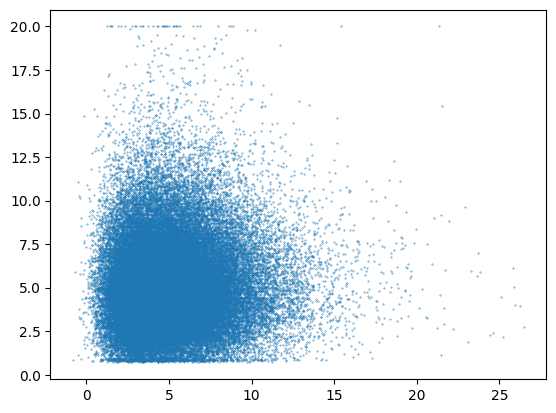

In [99]:
pl.figure()
pl.scatter(ch_total_mock[::10], csim_true[::10], s=0.1)
# pl.scatter(cfunc_true[::10], csim_true[::10], s=0.1)




In [56]:
X_conc_sim.shape
# c_halos_all_sort.shape[:-2]

(1, 2097152, 12)

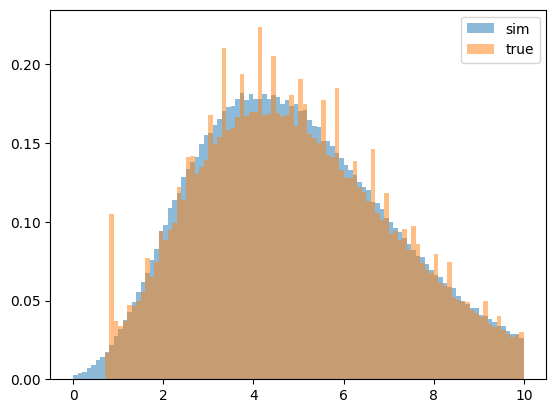

In [102]:
pl.figure()
_ = pl.hist(ch_total_mock, bins=100, alpha=0.5, label='sim', density=True, range=(0,10))
_ = pl.hist(csim_true, bins=100, alpha=0.5, label='true', density=True, range=(0,10))
# pl.yscale('log')
pl.legend()


In [41]:
# df_ch_sim_total.shape
# c_halos_all_sort.shape


(512, 4096, 12)

In [34]:
from colossus.halo import mass_so
isim = 0
is_fid = True
z_REDSHIFT = 0.5
if is_fid:
    snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/fiducial_HR'
else:
    snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
snapnum = 3
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
lgMass_truth = np.log10(mass_truth).astype(np.float32)
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]
Rs = rockstar[:,header.index('Rs')]


indsel = np.where(mass_truth > 5e12)[0]
pos_h_truth = pos_h_truth[indsel]
vel_h_truth = vel_h_truth[indsel]
lgMass_truth = lgMass_truth[indsel]
mass_truth = mass_truth[indsel]
Rs = Rs[indsel]
Rhalo = (1+z_REDSHIFT)*mass_so.M_to_R(mass_truth, z_REDSHIFT, '200c')   
conc_truth = Rhalo/Rs




/tmp/ipykernel_75032/2937974782.py:21: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


In [35]:
conc_truth.shape


(654697,)